## Quantized Transfer Learning

Transfer learning is a way of re-training the pretrained model into different datasets and there are three ways to do it:

1. ConvNet as a fixed feature extractor: 

Freeze the weights of all the parameters in the network except that of the final several layers (aka “the head”, usually fully connected layers). Thus, these last layers are trained to make the expected/desired outputs using feature maps from the pretrained model.

2. Finetuning the ConvNet:

The pretrained model is also re-trained/fine-tuned with the final layers(head) for different datasets. The simple know-how is that in this method, **it is common to set the learning rate as a smaller number.** 

3. train the last layers with freezing the Convnet, and then train both:

First, you can freeze the feature extractor, and train the head. After that, you can unfreeze the feature extractor (or part of it), set the learning rate to something smaller, and continue training.


In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

plt.ion()

##### Create Datasets

In [4]:
batch_size = 16
num_workers = 8

In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [6]:
data_transforms = {'train': transforms.Compose([
                            transforms.Resize(224),
                            transforms.RandomCrop(224),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize(mean, std)
                            ]),
                    'val': transforms.Compose([
                            transforms.Resize(224),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(mean, std)
                            ])
                   }

In [7]:
data_dir = '../../../data/hymenoptera_data'

data_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
data_loaders = {x: torch.utils.data.DataLoader(data_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)
                for x in ['train', 'val']}

In [13]:
dataset_sizes = {x: len(data_datasets[x]) for x in ['train', 'val']}

class_names = data_datasets['train'].classes

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
def imshow(inp, title=None, ax=None, figsize=(5, 5)):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if ax is None:
        fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(inp)
    ax.set_xticks([])
    ax.set_yticks([])
    if title is not None:
        ax.set_title(title)

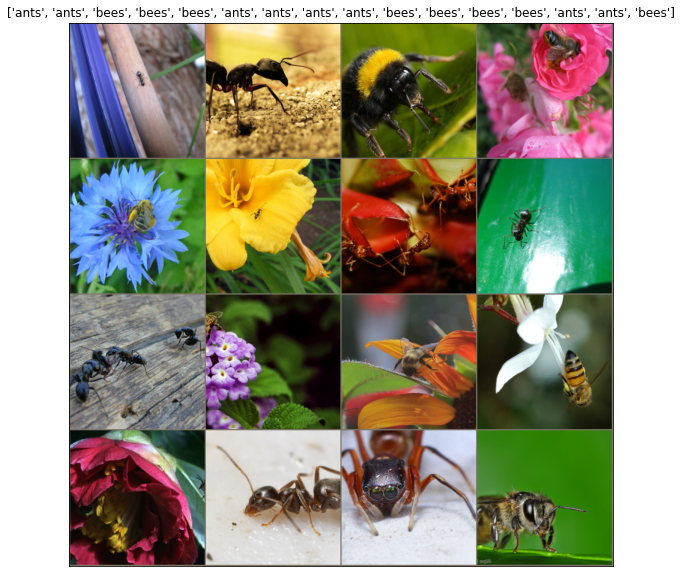

In [16]:
# Get a batch of training data
inputs, classes = next(iter(data_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title=[class_names[x] for x in classes], ax=ax)

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

            # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
                            time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

##### Visualize model prediction

In [18]:
def visualize_model(model, rows=3, cols=3):
    was_training = model.training
    model.eval()
    current_row = current_col = 0
    fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

    with torch.no_grad():
        for idx, (imgs, lbls) in enumerate(data_loaders['val']):
            imgs = imgs.cpu()
            lbls = lbls.cpu()

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            for jdx in range(imgs.size()[0]):
                imshow(imgs.data[jdx], ax=ax[current_row, current_col])
                ax[current_row, current_col].axis('off')
                ax[current_row, current_col].set_title('predicted: {}'.format(class_names[preds[jdx]]))

                current_col += 1
                if current_col >= cols:
                    current_row += 1
                    current_col = 0
                if current_row >= rows:
                    model.train(mode=was_training)
                    return
                model.train(mode=was_training)

### Part 1. Training a Custom Classifier based on a Quantized Feature Extractor

you will use a “frozen” quantized feature extractor, and train a custom classifier head on top of it. ***Unlike floating point models, you don’t need to set requires_grad=False for the quantized model, as it has no trainable parameters.*** 

> no trainable parameters in quantized model?

In [19]:
import torchvision.models.quantization as models

In [20]:
model_fe = models.resnet18(pretrained=True, progress=True, quantize=True)
num_ftrs = model_fe.fc.in_features

In [21]:
model_fe

QuantizableResNet(
  (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.028605546802282333, zero_point=0, padding=(3, 3))
  (bn1): Identity()
  (relu): Identity()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): QuantizableBasicBlock(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.016524722799658775, zero_point=0, padding=(1, 1))
      (bn1): Identity()
      (relu): Identity()
      (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.04645531252026558, zero_point=75, padding=(1, 1))
      (bn2): Identity()
      (add_relu): QFunctional(scale=0.03447607904672623, zero_point=0)
    )
    (1): QuantizableBasicBlock(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.017180869355797768, zero_point=0, padding=(1, 1))
      (bn1): Identity()
      (relu): Identity()
      (conv2): QuantizedConv2d

At this point you need to modify the pretrained model. ***The model has the quantize/dequantize blocks in the beginning and the end. However, because you will only use the feature extractor, the dequantizatioin layer has to move right before the linear layer (the head). The easiest way to do that is to wrap the model in the nn.Sequential module.***

> quantize/dequantize blocks?

The first step is to isolate the feature extractor in the ResNet model. Although in this example you are tasked to use all layers except fc as the feature extractor, in reality, ***you can take as many parts as you need.*** This would be useful in case you would like to replace some of the convolutional layers as well.

***When separating the feature extractor from the rest of a quantized model, you have to manually place the quantizer/dequantized in the beginning and the end of the parts you want to keep quantized.***

> what??!!

The function below creates a model with a custom head.



In [107]:
def create_combined_model(model_fe):
    # Step 1. Isolate the feature extractor.
    model_fe_features = nn.Sequential(
    model_fe.quant,  # Quantize the input
    model_fe.conv1,
    model_fe.bn1,
    model_fe.relu,
    model_fe.maxpool,
    model_fe.layer1,
    model_fe.layer2,
    model_fe.layer3,
    model_fe.layer4,
    model_fe.avgpool,
    model_fe.dequant,  # Dequantize the output
    )

    # Step 2. Create a new "head"
    new_head = nn.Sequential(
                    nn.Dropout(p=0.5),
                    nn.Linear(num_ftrs, 2),
    )

    # Step 3. Combine, and don't forget the quant stubs.
    new_model = nn.Sequential(
                    model_fe_features,
                    nn.Flatten(1),
                    new_head,
    )
    
    return new_model

Currently the quantized models can only be run on CPU. However, it is possible to send the non-quantized parts of the model to a GPU.



In [108]:
import torch.optim as optim

new_model = create_combined_model(model_fe)
new_model = new_model.to('cpu')

criterion = nn.CrossEntropyLoss()

# Note that we are only training the head.
optimizer_ft = optim.SGD(new_model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

This step takes around 15-25 min on CPU. Because the quantized model can only run on the CPU, you cannot run the training on GPU.

In [ ]:
new_model = train_model(new_model, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=25, device='cpu')

visualize_model(new_model)
plt.tight_layout()

Epoch 0/24
----------
train Loss: 0.4540 Acc: 0.8074
val Loss: 0.3202 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.5094 Acc: 0.8689
val Loss: 0.3771 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.3517 Acc: 0.9262
val Loss: 0.2794 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.2982 Acc: 0.9221
val Loss: 0.2646 Acc: 0.9608

Epoch 4/24
----------
train Loss: 0.3784 Acc: 0.9262
val Loss: 0.3140 Acc: 0.9608

Epoch 5/24
----------
train Loss: 0.1698 Acc: 0.9549
val Loss: 0.3242 Acc: 0.9673

Epoch 6/24
----------
train Loss: 0.2081 Acc: 0.9467
val Loss: 0.3689 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.1934 Acc: 0.9631
val Loss: 0.3628 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.2529 Acc: 0.9549
val Loss: 0.3672 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.1914 Acc: 0.9590
val Loss: 0.3612 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.0582 Acc: 0.9877
val Loss: 0.3349 Acc: 0.9673

Epoch 11/24
----------
train Loss: 0.2742 Acc: 0.9262
val Loss: 0.3282 Acc: 0.9542

Ep